# Imports

In [122]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymongo import MongoClient
import csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spacy
import tweepy

# Help-Functions

In [123]:
def open_csv(csv_address):
    '''Loading CSV document with token bearer for conection with Twitter API'''
    with open(csv_address, 'r', encoding = 'utf8') as file:
        reader = csv.reader(file)
        data = list(reader)
        file.close()
    return data[0][1]


def conection_twitter(bearer_token):
    ''' Connecting with Twitter API'''
    # Access key
    client = tweepy.Client(bearer_token=bearer_token)
    return client


def mongo_connection(database_name):
    '''Connecting with Mongo DB and creating Database'''
    client = MongoClient('localhost', 27017)
    # Creating database or connecting
    db = client[database_name]
    return db


def load_tweet(candidate_dict:dict, client_twitter, data_base, maximum_results: int = 100):
    '''Using tweetpy API for loading tweets'''
    # Accessing a dictionary that contains name as key and id as value
    for key, value in candidate_dict.items():
        # Creating a collection in MongoDB using key in dictionary as name
        collection = data_base[key]
        
        # Collecting tweets ussing method .get_users_id from tweepy
        tweets = client_twitter.get_users_tweets(id= value,
                                                 tweet_fields = ['created_at',
                                                                    'lang',
                                                                    'public_metrics',
                                                                    'reply_settings',
                                                                    'entities',
                                                                    'referenced_tweets',
                                                                    'in_reply_to_user_id'],
                                                expansions='referenced_tweets.id.author_id',
                                                max_results=maximum_results)
        
        # Using iteration to create variables that will receive data in each tweet, to insert a tweet into the MongoDB collection.
        for tweet in tweets.data:
            
            tweet_id = tweet.id
            user_id = value
            texto = tweet.text
            data = tweet.created_at
            likes = tweet.public_metrics['like_count']
            retweet_count = tweet.public_metrics['retweet_count']
            reply_count = tweet.public_metrics['reply_count']
            quote_count = tweet.public_metrics['quote_count']
            retweet_origen_id = tweet.referenced_tweets
            try:
                link = tweet.entities['urls'][0]['expanded_url']
            except:
                link = ('Null')
                
            # Error handling for Tweet Id already added, because mongo db does not accept repeated Ids
            try:
                collection.insert_one({
                                '_id': tweet_id,
                                'user_id':user_id, 
                                'texto': texto,
                                'data': data,
                                'likes': likes,
                                'retweet_count':retweet_count,
                                'reply_count': reply_count,
                                'quote_count': quote_count,
                                'retweet_origen_id': retweet_origen_id,
                                'link': link
                                })
            except:
                pass


def extract_words(data):
    '''Extracting stopwords for text in tweets using spacy'''
    stop_words = stopwords.words('portuguese')
    texto = data['texto'].to_list()
    
    # Removing stopwords
    striped_phrase = []
    for element in texto:
        words = word_tokenize(element)
        for word in words:
            if word not in stop_words:
                word = word.strip(',:.#')
                word = word.replace('https', '')
                if len(word) >=3:
                    striped_phrase.append(word)
    'Removing whitespaces in a list'
    str_list = list(filter(None, striped_phrase))  
    return str_list


def create_label(word_list):
    '''Using trained pipelines for Portuguese linguage fron spacy library to create label on each word in the list'''
    nlp_lg = spacy.load("pt_core_news_lg")
    #To instantiate the object it is necessary that it is in a string in text format
    str1 = ", " 
    #Adds an empty space to each word of the comma
    stem2 = str1.join(word_list)
    #Instance text as spacy object
    stem2 = nlp_lg(stem2)
    #Using a Comprehension list to create a selected list of text and label '''
    label_lg = [(X.text, X.label_) for X in stem2.ents]
    return label_lg


def create_df(word_label, term: str, max_rows: int):
    '''Creating DataFrame with labels, term of occurrence, and total of DataFrame rows.'''
    upper = term.upper()
    df = pd.DataFrame(word_label, columns = ['Word','Entity'])
    #Entity filtering   
    df_org = df.where(df['Entity'] == upper)
    #Creates a repeated word count
    df_org_count = df_org['Word'].value_counts()
    #Selecting the most commonly used words
    df = df_org_count[:max_rows]
    return df


def create_plot(df, title: str, size: tuple ):
    '''Creating a barplot'''
    title_save = title.replace(' ', '-').lower()
    
    path = 'images'
    
    plt.figure(figsize= size)
    sns.barplot(df.values, df.index, alpha=0.8)
    plt.title(title)
    plt.ylabel('Word from Tweet', fontsize=12)
    plt.xlabel('Count of Words', fontsize=12)
    
    plt.savefig(path + '/' + title_save + '.png', dpi = 300, transparent = True, bbox_inches='tight')
    
    plt.show()

# Dictionary with candidates

In [124]:
# Dict where key = User, Value = Id User
candidate_dict = {
    'Bolsonaro':'128372940',
    'Ciro': '33374761',
    'Lula': '2670726740',
    'Sergio_Moro': '1113094855281008641' 
}

# Creating connection to Twitter API

In [125]:
# Load a token from csv
token = open_csv('C:/Users/Diego/OneDrive/Cursos e codigos/Codigos/twitter/bearertoken.csv')

# Connecting with Twitter API
client_twitter = conection_twitter(token)

# Creating connection to MongoDB Database

In [126]:
# Creating connection to MongoDB Database
db = mongo_connection('data_twitter')

# Load tweets and insert then inside MongoDB Collections

In [127]:
# Load tweets and insert then inside MongoDB Collections
load_tweet(candidate_dict = candidate_dict,
           client_twitter = client_twitter,
           data_base = db,
           maximum_results = 5)

# Connecting with Collections and Loading DataFrames from MongoDB

In [128]:
# Connecting with collections from MongoDb
collection_Bolsonaro = db.Bolsonaro
collection_Ciro = db.Ciro
collection_Lula = db.Lula
collection_SergioMoro = db.Sergio_Moro

In [129]:
# Loading DataFrames from MongoDB
df_bol = pd.DataFrame(collection_Bolsonaro.find())
df_cir = pd.DataFrame(collection_Ciro.find())
df_lul = pd.DataFrame(collection_Lula.find())
df_ser = pd.DataFrame(collection_SergioMoro.find())

# Operations in DataFrame

In [130]:
# Extracting words fron DataFrame and remove stopwords
bol_words = extract_words(df_bol)
cir_words = extract_words(df_cir)
lul_words = extract_words(df_lul)
ser_words = extract_words(df_ser)

In [131]:
# Creating labels from the list, uning spacy
bol_label = create_label(bol_words)
cir_label = create_label(cir_words)
lul_label = create_label(lul_words)
ser_label = create_label(ser_words)

In [132]:
# Creating DataFrame with labels, term of occurrence, and total of DataFrame rows.
bol_df_loc = create_df(bol_label, 'LOC', 30)
cir_df_loc = create_df(cir_label, 'LOC', 30)
lul_df_loc = create_df(lul_label, 'LOC', 30)
ser_df_loc = create_df(ser_label, 'LOC', 30)

# Views of the top location mentioned by each candidate

In [133]:
# Creating DataFrame with labels, term of occurrence, and total of DataFrame rows.
bol_df_loc = create_df(bol_label, 'LOC', 30)
cir_df_loc = create_df(cir_label, 'LOC', 30)
lul_df_loc = create_df(lul_label, 'LOC', 30)
ser_df_loc = create_df(ser_label, 'LOC', 30)

C:\Users\Diego\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


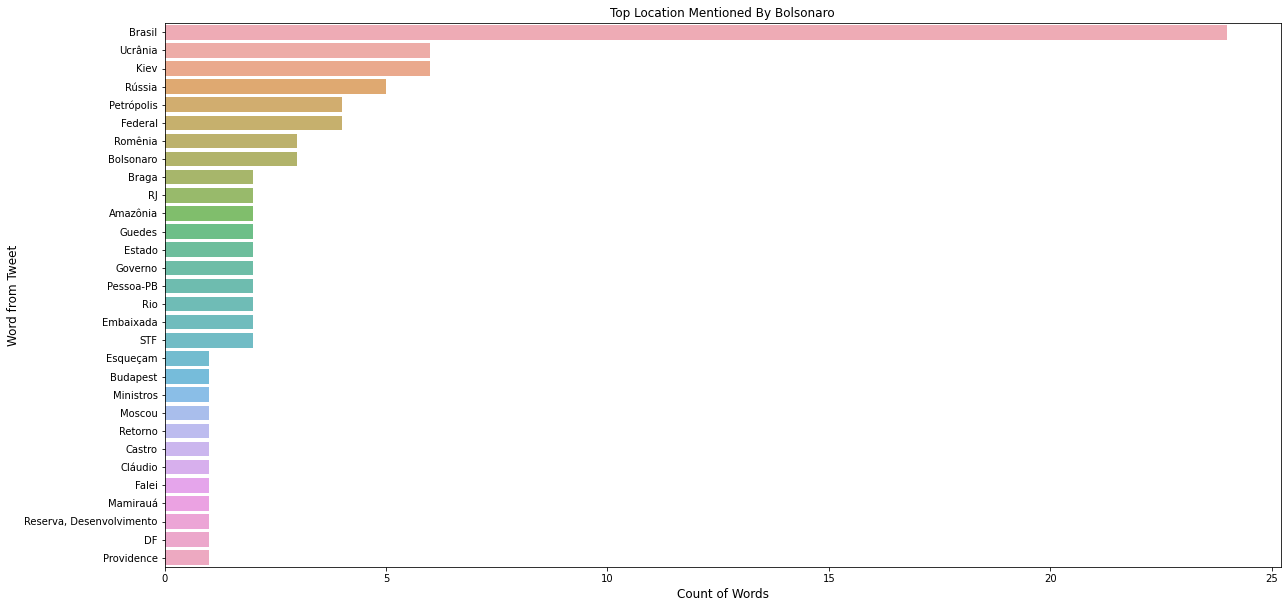

C:\Users\Diego\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


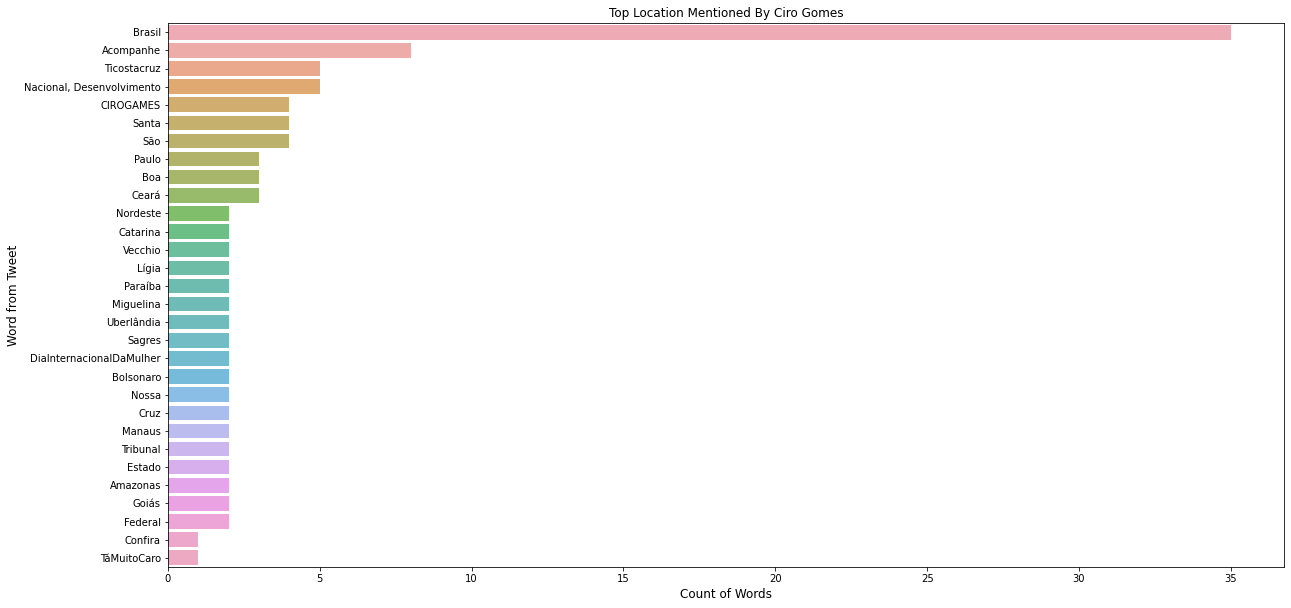

C:\Users\Diego\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


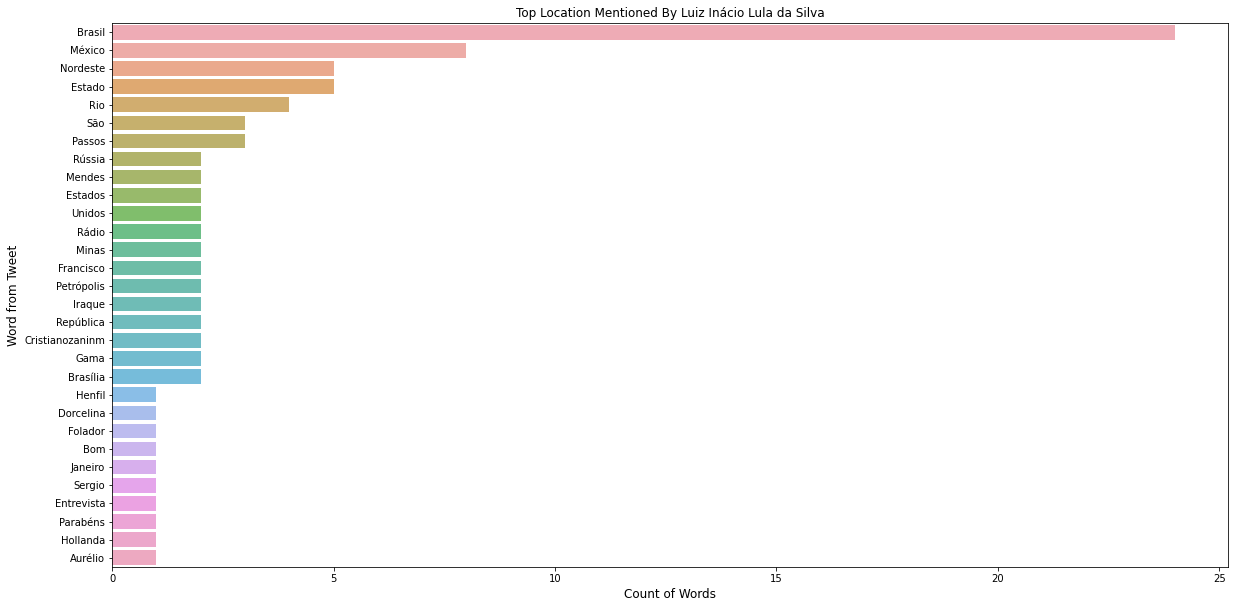

C:\Users\Diego\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


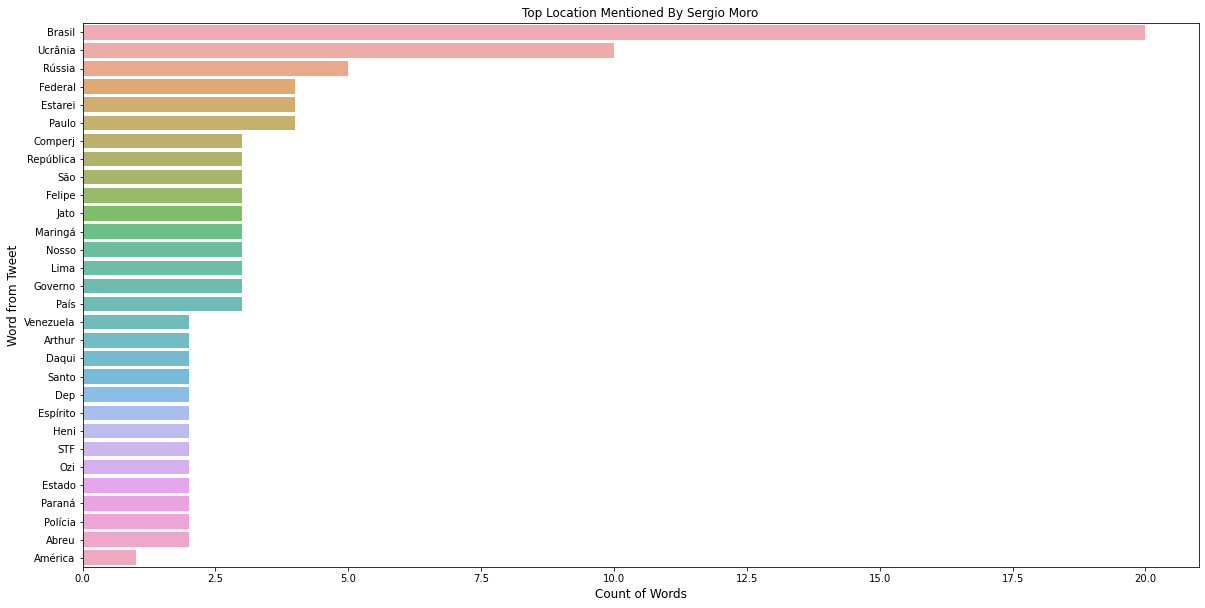

In [134]:
# Creating plots from DataFrames 
bol_plot = create_plot(bol_df_loc, 'Top Location Mentioned By Bolsonaro', (20,10))
cir_plot = create_plot(cir_df_loc, 'Top Location Mentioned By Ciro Gomes', (20,10))
lul_plot = create_plot(lul_df_loc, 'Top Location Mentioned By Luiz Inácio Lula da Silva', (20,10))
ser_plot = create_plot(ser_df_loc, 'Top Location Mentioned By Sergio Moro', (20,10))

# Views of the top persons mentioned by each candidate

In [135]:
bol_df_loc = create_df(bol_label, 'PER', 30)
cir_df_loc = create_df(cir_label, 'PER', 30)
lul_df_loc = create_df(lul_label, 'PER', 30)
ser_df_loc = create_df(ser_label, 'PER', 30)

C:\Users\Diego\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


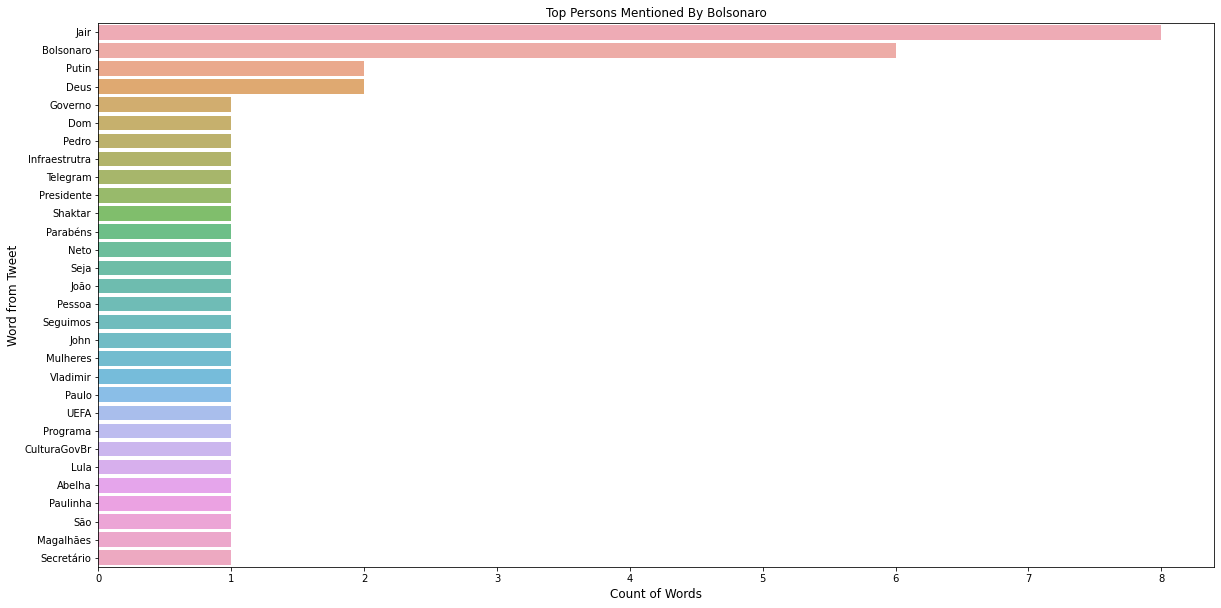

C:\Users\Diego\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


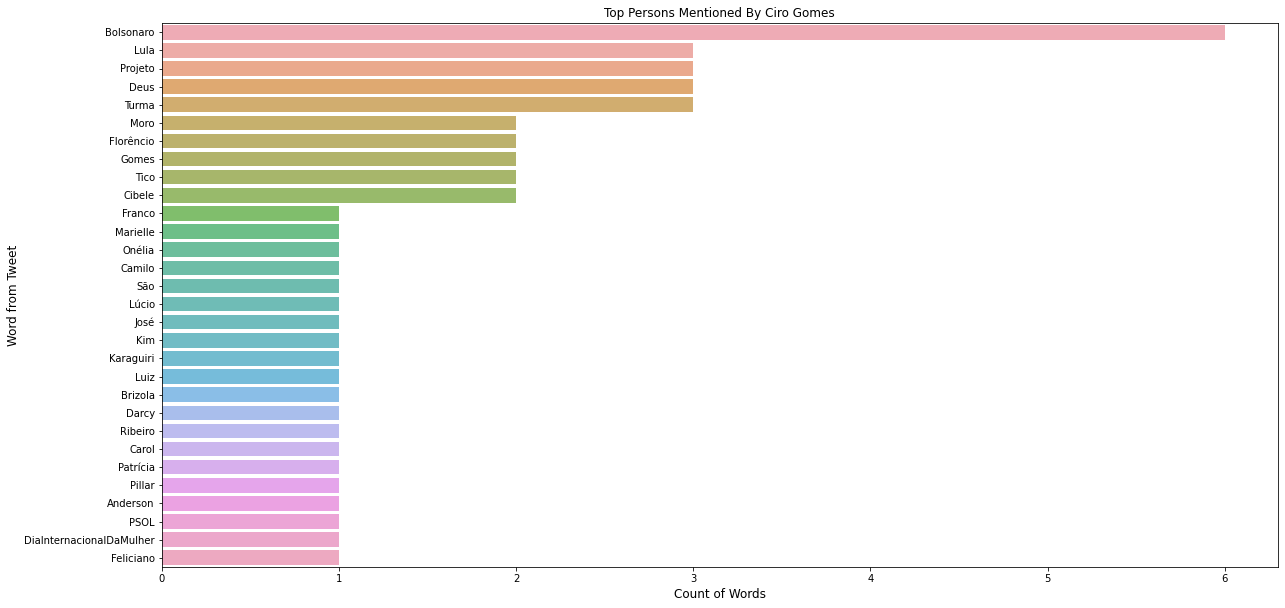

C:\Users\Diego\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


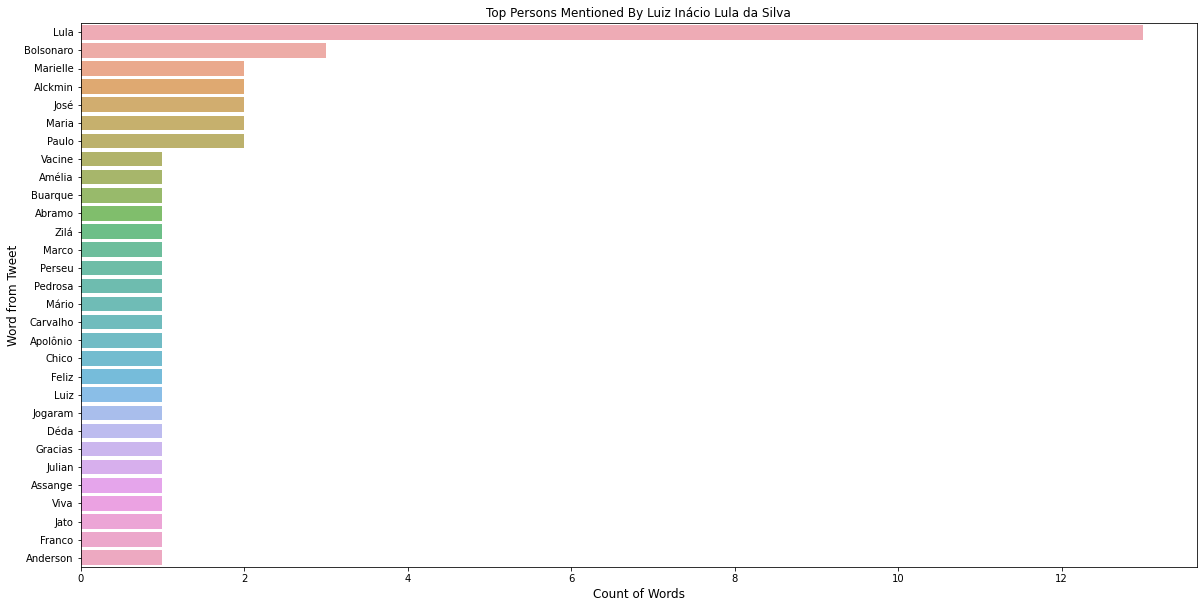

C:\Users\Diego\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


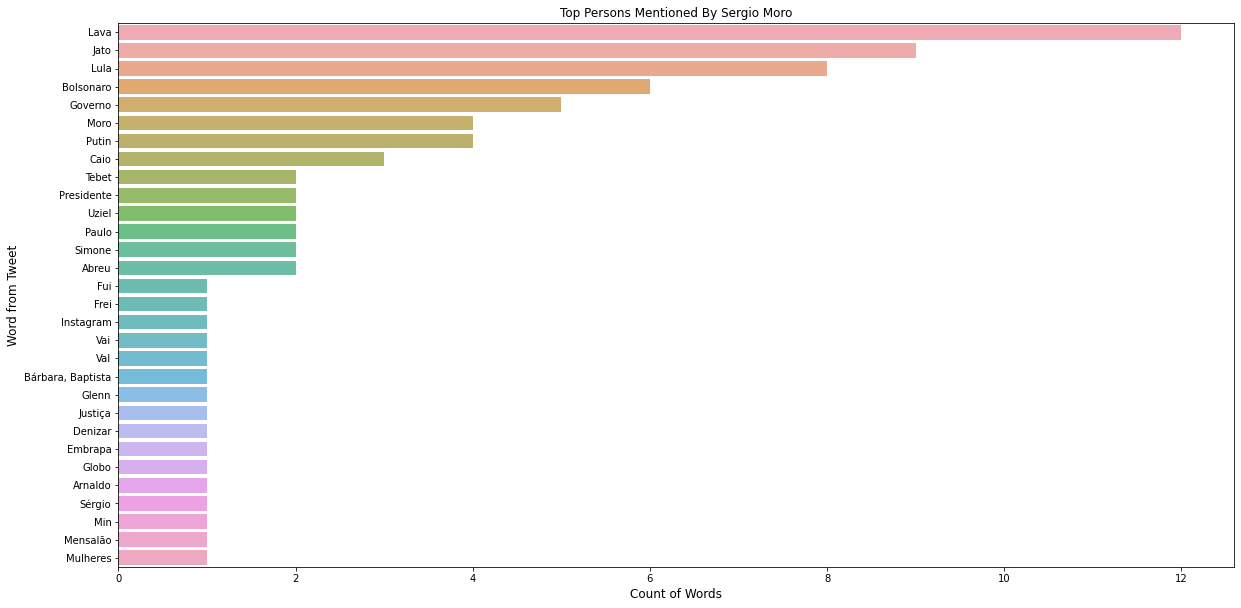

In [136]:
bol_plot = create_plot(bol_df_loc, 'Top Persons Mentioned By Bolsonaro', (20,10))
cir_plot = create_plot(cir_df_loc, 'Top Persons Mentioned By Ciro Gomes', (20,10))
lul_plot = create_plot(lul_df_loc, 'Top Persons Mentioned By Luiz Inácio Lula da Silva', (20,10))
ser_plot = create_plot(ser_df_loc, 'Top Persons Mentioned By Sergio Moro', (20,10))

# Views of the top organizations mentioned by each candidate

In [137]:
bol_df_loc = create_df(bol_label, 'ORG', 30)
cir_df_loc = create_df(cir_label, 'ORG', 30)
lul_df_loc = create_df(lul_label, 'ORG', 30)
ser_df_loc = create_df(ser_label, 'ORG', 30)

C:\Users\Diego\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


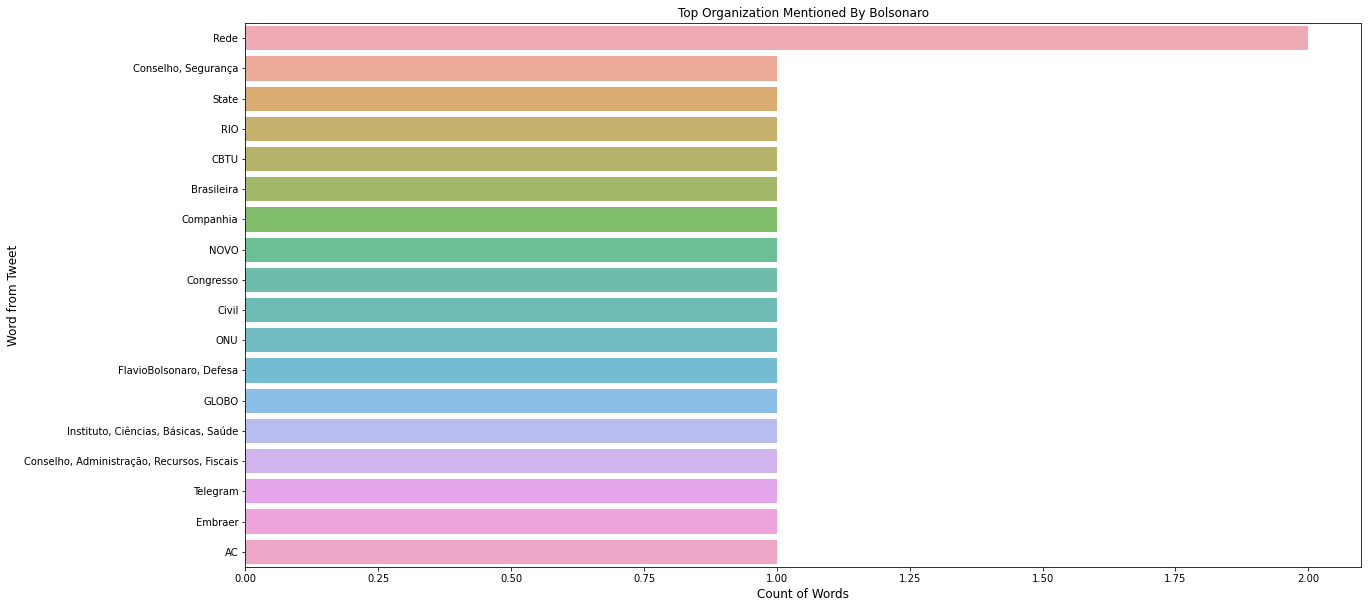

C:\Users\Diego\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


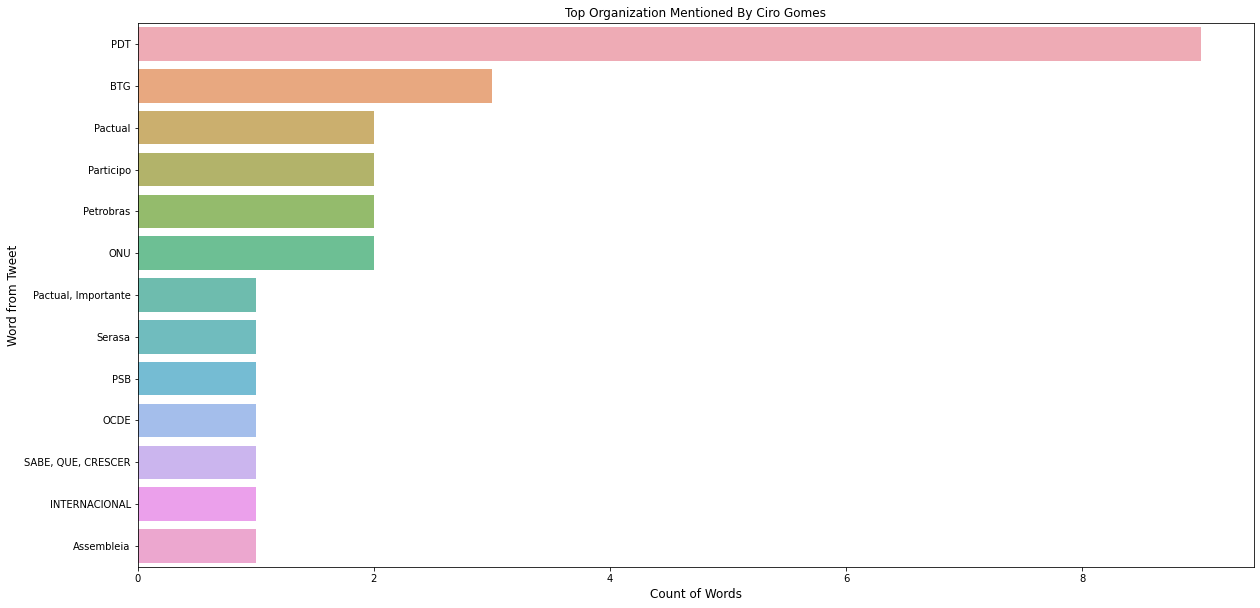

C:\Users\Diego\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


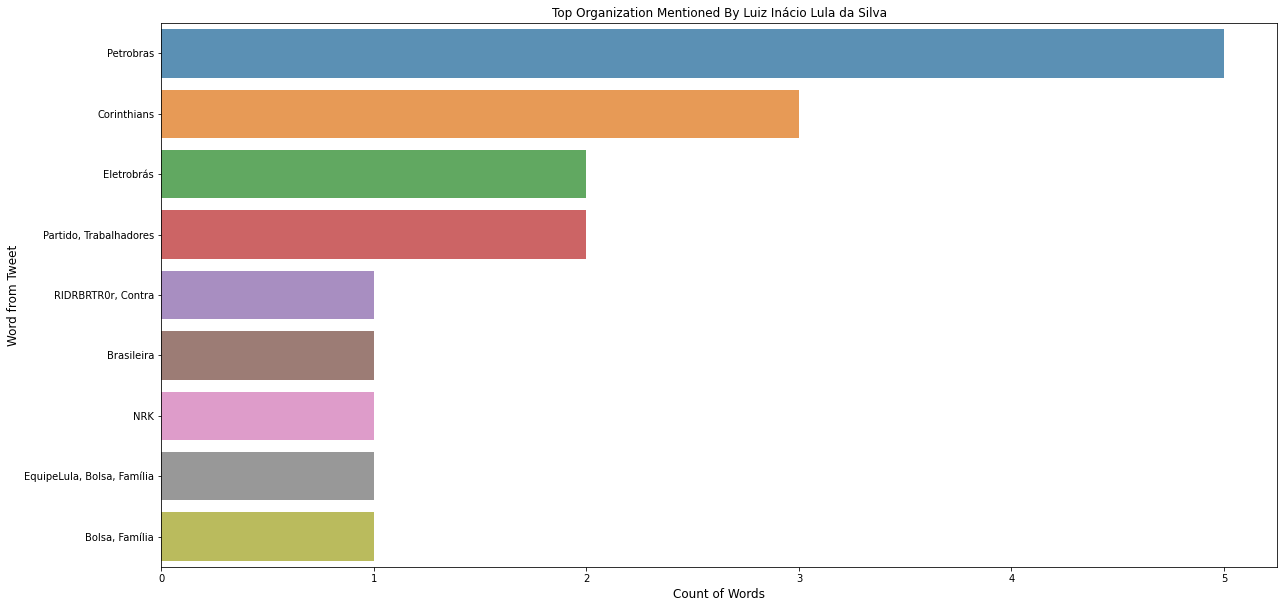

C:\Users\Diego\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


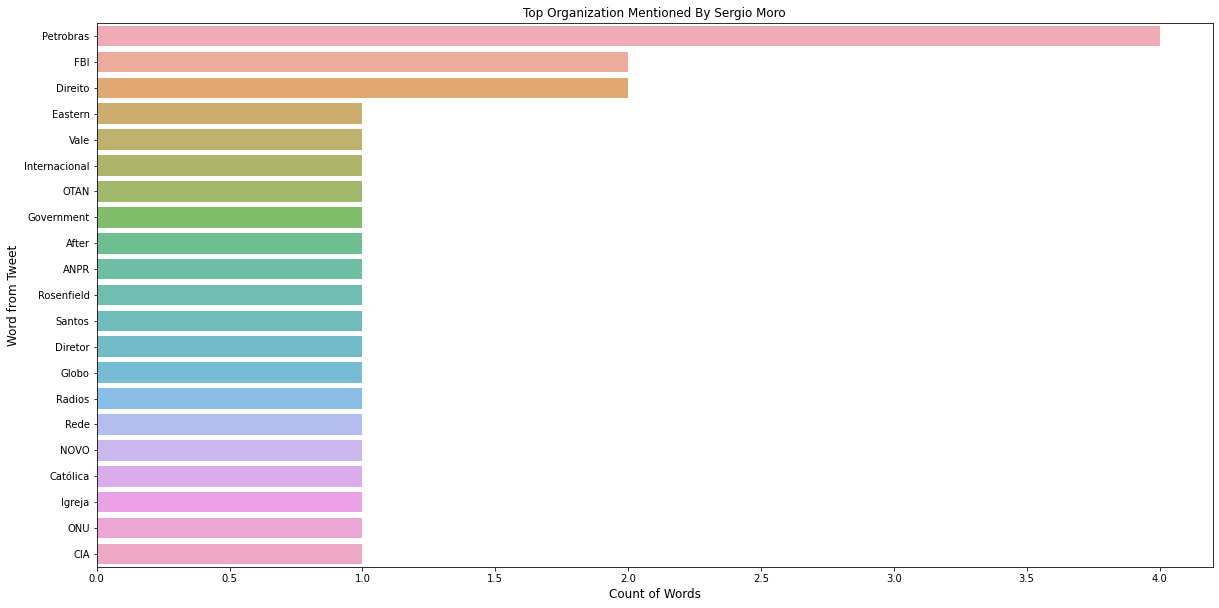

In [138]:
bol_plot = create_plot(bol_df_loc, 'Top Organization Mentioned By Bolsonaro', (20,10))
cir_plot = create_plot(cir_df_loc, 'Top Organization Mentioned By Ciro Gomes', (20,10))
lul_plot = create_plot(lul_df_loc, 'Top Organization Mentioned By Luiz Inácio Lula da Silva', (20,10))
ser_plot = create_plot(ser_df_loc, 'Top Organization Mentioned By Sergio Moro', (20,10))